<a href="https://colab.research.google.com/github/meghutch/Breast-Cancer-Classification-Clinical-Genomic/blob/master/Gene_Expression_Analysis_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Clinical Outcomes of Breast Cancer Patients - Gene Expression Data**

## **Principal Component Analysis**

**Author:** Meg Hutch

**Date:** November 19, 2019

**Objective:** Apply Principal Component Analysis to Determine Which Genes to Include into our Neural Network 

****Update: I previously did some testing and these methods don't seem to be causing significant differences. I will probably just need to later validate whether the PC change using the different methods, but for now, I think I can go ahead, clean up the code****

**References**

* https://www.youtube.com/watch?v=Lsue2gEM9D0&list=PLblh5JKOoLUIcdlgu78MnlATeyx4cEVeR&index=54&t=0s

* https://www.youtube.com/watch?v=FgakZw6K1QQ

* https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 

* https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python 

* https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [0]:
# Connect Colab to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import Data
gene_data = pd.read_csv('/content/drive/My Drive/Projects/Breast_Cancer_Classification/Data/merged_expression.txt', sep=',')

In [0]:
#gene_data.head()
#genes.info()

# **Data Pre-Processing**

**Check if NAs**

In [0]:
gene_data.isna().any()

Unnamed: 0    False
EVENT          True
OS_MONTHS     False
FIVE_YEAR      True
RERE          False
              ...  
CC2D1A        False
CB986545      False
IGSF9         False
DA110839      False
FAM71A         True
Length: 24372, dtype: bool

**Remove cases where there are missing values**

In [0]:
gene_data = gene_data.dropna()

**Check number of patients after removing Nas**

In [0]:
gene_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1747 entries, 0 to 1903
Columns: 24372 entries, Unnamed: 0 to FAM71A
dtypes: float64(24371), object(1)
memory usage: 324.9+ MB


**Create a dataset just containing gene expression**

In [0]:
# remove event, os_motnhs, and Five_Year from the dataset
genes = gene_data.drop(columns=["Unnamed: 0", "EVENT", "OS_MONTHS", "FIVE_YEAR"])

**Create a dataset containing the target variables**

In [0]:
# Subset only the Event - whether they lived (0) or died (1) from Breast Cancer
labels = gene_data.EVENT

# Create a list of row names
patients = list(genes.index)

# Convert labels into a dataframe and indicate patients as the index
labels = pd.DataFrame(labels, index = patients)

print(labels)

      EVENT
0       0.0
1       0.0
2       1.0
3       0.0
4       1.0
...     ...
1899    0.0
1900    1.0
1901    1.0
1902    0.0
1903    0.0

[1747 rows x 1 columns]


**Save Gene Dataset**

Save the genetic data sets that did not have missing values

In [0]:
gene_data.to_csv('/content/drive/My Drive/Projects/Breast_Cancer_Classification/Processed_Data/all_gene_data.txt')

# **Principal Component Analysis**

**What is a Pricipal Component? (From DataCamp)**

Principal componenets have both direction and magnitude. The direction represents across which principal axes the data is mostly spread out or has the most variance and the magnitude signifies the amount of varaince that Principal Component captures of the data when projected onto that axis. 

The principal components are a straight line, and the first principal component holds the most variance in the data. Each subsequent prinicpal component is orthogonal to the last and has a lesser variance .

Correlated features contribute to the same principal component, thereby reducing the original data features into uncorrelated prinicpal components; each representing a different set of correlated features with differents of variation.

Each principal component represents a percentage of total variation captured from the data

****Note:** I troubleshooted some discrepancies among the references above in regards to fit and fit transform. Some articles would initially use fit_transform to scale and then again used pca.fit_transform when identifying prinicipal components, other references, instead of fit_transform just used pca.transform for this step. I tested both methods and got the same results. Actually looks like maybe using fit_transform is probably just combining these steps?****** 


**1) Standardize the Data**

Must scale features in your data before applying PCA. **StandardScaler** helps standardize features onto unit scale (mean = 0 and standard deviation = 1). Thus, each value in the dataset will have the sample mean value subtracted and then divided by the standard deviation of the whole dataset. 


In [0]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

# Stanardize/Scale the data
x = StandardScaler().fit_transform(genes)

**Let's check whether the normalized data has a mean of zero and a standard deviation of 1**

In [0]:
np.mean(x), np.std(x)

(4.1760406566772064e-19, 0.9999999999999999)

**Convert the normalized features into tabular format**

In [0]:
# Create list of column names
features = list(genes.columns.values) 

# Create data frame of newly normalized data - use patients IDs as the index 
x = pd.DataFrame(x, columns = features, index = patients)

**2) Determine Prinicpal Components**

Reference: https://stackoverflow.com/questions/42167907/understanding-scikitlearn-pca-transform-function-in-python

**pca.fit** allows PCA function to compute vectors that you can project your data onto in order to reduce the dimension of your data. 

**pca.transform** actually performs the projection. It projects each row of data into the vector space that was learned when fit was called.

from sklearn: **fit_transform**: Fit the model with X and apply the dimensionality reduction on X

In [0]:
# Define pca function
pca = PCA()

# Fit to the scaled/standardized data - then use transform to prokect into the new vector space learned by fit
principalComponents = pca.fit_transform(x)

# Generate a list of column names with the number for each prinicpal component 
col_names = [f'pc{i}' for i in range(1, 1748)] # there are 1747 samples - so we want to have range of 1 less than 1748 column names 

# Add column names to the principal component dataset 
principalDf = pd.DataFrame(principalComponents, columns = col_names, index = patients)

In [0]:
principalDf 

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,...,pc1708,pc1709,pc1710,pc1711,pc1712,pc1713,pc1714,pc1715,pc1716,pc1717,pc1718,pc1719,pc1720,pc1721,pc1722,pc1723,pc1724,pc1725,pc1726,pc1727,pc1728,pc1729,pc1730,pc1731,pc1732,pc1733,pc1734,pc1735,pc1736,pc1737,pc1738,pc1739,pc1740,pc1741,pc1742,pc1743,pc1744,pc1745,pc1746,pc1747
0,-46.927916,4.739976,-55.999332,32.035664,19.910327,22.467124,-9.464583,27.687378,40.899387,17.413664,12.874125,23.709718,-15.148509,-0.865481,9.578451,43.509412,8.147583,-0.626041,17.645039,-1.618802,9.019847,4.457706,4.518250,-4.937904,-24.213609,8.105994,13.850133,1.111403,6.630694,-3.497717,7.405129,-6.764970,6.955681,-2.208536,20.362868,1.950536,4.004424,-5.765875,14.492081,-1.443265,...,2.353436,1.680148,0.502169,1.247080,-0.962811,0.385817,0.871507,-2.201203,0.761591,-3.156483,0.331051,-0.703946,-0.146786,-1.998286,-1.131290,0.189897,-0.511533,1.900914,-0.181689,-1.004616,1.497246,-1.563271,-0.864876,0.249439,-0.870708,1.401435,0.314823,-0.070911,-7.889290,-2.685330,-2.326405,-1.369807,0.192507,1.453147,1.454840,-0.439513,0.493475,0.105313,-0.492231,6.766752e-15
1,-11.099104,-33.901894,15.785114,-4.082658,-4.467048,13.386620,-3.602027,-9.460577,13.669762,-10.658357,5.732476,-4.388901,-30.802218,-11.101859,-9.150638,-18.567117,4.756882,7.048982,-40.085906,10.763511,8.341258,0.161962,6.882540,4.774633,3.674660,9.483629,2.278378,16.801364,-6.104713,-5.760067,5.589340,0.146233,-19.578341,-1.117433,2.159414,-0.804954,8.215614,-14.119656,-1.601074,-26.671501,...,1.031880,0.345586,1.139115,-0.060822,-0.698941,0.342868,-0.296810,2.326502,-1.250184,0.580932,2.046352,2.343894,1.483325,-1.265529,-1.346815,1.698744,-0.596339,-1.134852,-0.511363,0.428665,-1.396380,0.736282,-0.818182,-0.522198,-1.246614,1.264074,0.691885,0.935606,-0.700082,0.167398,0.929812,2.266908,0.196243,-2.585104,-2.485255,-0.162657,0.026969,-1.019625,0.011169,6.766752e-15
2,-96.985059,-24.940906,28.624658,36.686919,-30.138800,11.416279,14.569905,-46.678033,-3.364675,3.969207,0.891319,-13.955752,12.792117,19.411776,18.536698,9.425662,13.734446,1.497408,-8.534976,18.240748,9.333484,-5.292072,0.957113,10.117796,10.855034,4.348019,2.285662,12.438302,-6.132481,-1.554175,9.490339,-12.595310,-9.525302,-6.433478,-13.658776,7.712239,3.752626,-8.410007,-1.828502,-18.692607,...,-2.796961,1.651215,-0.477119,-1.005758,2.323221,0.415255,-3.008175,1.303572,-0.327661,-0.465163,1.156033,-0.249526,-0.075100,0.570273,1.683425,-1.339252,-0.484451,0.768586,-1.752514,-3.467120,-1.126820,2.211725,-0.453516,-0.351369,-2.548713,0.297190,0.268970,-0.537406,-2.513105,0.018479,-0.518864,2.770224,0.587882,1.428211,-0.893350,0.402909,1.015733,-0.716538,-0.715863,6.766752e-15
3,-88.693561,-21.679808,45.812435,70.598700,-13.705619,2.806051,27.613431,-30.230731,2.462651,-26.603622,5.833794,10.598025,10.449427,30.320269,-3.339759,14.762800,20.286133,-1.838540,-4.101172,4.090638,1.929492,-3.241216,3.179941,13.207027,11.827730,5.234861,-16.755167,-5.536135,-22.167629,-9.748619,-7.178764,-8.118227,3.053096,-1.646036,-15.281099,19.653000,-3.006496,1.973012,6.478390,-6.277557,...,-1.759754,1.256679,-1.186898,-1.400255,-1.278223,1.773344,2.980416,2.031024,-1.345807,1.568314,2.124790,0.769984,-2.138613,-1.137067,0.261142,1.456147,-0.560683,0.649826,2.319222,-1.087604,-0.443428,1.103082,1.345145,1.467444,-0.067380,-2.280579,-0.515177,0.072687,-0.218214,0.898826,-0.999214,0.145761,-0.827297,1.166937,2.049148,-0.033257,0.560175,-0.165480,0.701716,6.766752e-15
4,-24.570044,-9.740202,23.784122,-29.528877,1.612231,-18.002656,5.038487,-7.691579,-0.683039,-23.345566,1.453569,-7.170600,-28.134315,12.000964,13.397635,21.759322,2.404912,8.328937,3.120519,-17.019949,-3.717521,4.008203,2.587010,8.357872,2.857080,8.202083,4.414469,25.864795,-13.155909,0.037880,-19.590891,-2.808960,7.117514,-10.624943,5.979798,-0.229612,-7.414543,3.089610,-3.394074

**3) Determine # of Components and Variance**

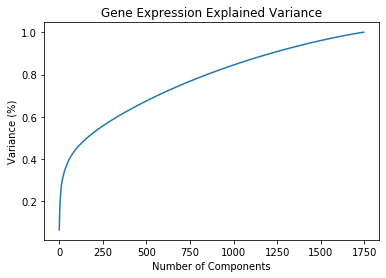

In [0]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Gene Expression Explained Variance')
plt.show()

The plot tells us that with ~1250 components we can capture 90% of the data. 

**Save All Principal Components**

In [0]:
principalDf.to_csv('/content/drive/My Drive/Projects/Breast_Cancer_Classification/Processed_Data/gene_pca_components_All_1747.txt')

**Alternative method - Pre-selecting % of variance**

**Fit PCA to the data**

In [0]:
pca = PCA(0.9)
x2 = pca.fit_transform(x)

In [0]:
x2 = pd.DataFrame(data = x2)
x2 #this is the 1213 principal components

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212
0,-46.927916,4.739976,-55.999332,32.035664,19.910327,22.467124,-9.464583,27.687378,40.899387,17.413664,12.874125,23.709718,-15.148509,-0.865481,9.578451,43.509412,8.147583,-0.626041,17.645039,-1.618802,9.019847,4.457706,4.518250,-4.937904,-24.213609,8.105994,13.850133,1.111403,6.630694,-3.497717,7.405129,-6.764970,6.955681,-2.208536,20.362868,1.950536,4.004424,-5.765875,14.492081,-1.443265,...,-2.101781,-2.619248,-1.977300,-1.160055,3.093098,-1.726845,2.134831,-5.074219,1.264507,-0.534047,-2.347654,-1.377870,1.539588,0.161884,-0.101084,1.113985,-0.026914,1.364764,-0.345376,-3.886792,1.150454,6.223514,0.702818,1.637886,2.329647,2.357557,4.300836,2.558626,2.829845,1.323680,-0.458878,2.773576,1.802263,3.820567,-1.299738,-0.279921,4.578414,-1.168474,0.071375,-0.146568
1,-11.099104,-33.901894,15.785114,-4.082658,-4.467048,13.386620,-3.602027,-9.460577,13.669762,-10.658357,5.732476,-4.388901,-30.802218,-11.101859,-9.150638,-18.567117,4.756882,7.048982,-40.085906,10.763511,8.341258,0.161962,6.882540,4.774633,3.674660,9.483629,2.278378,16.801364,-6.104713,-5.760067,5.589340,0.146233,-19.578341,-1.117433,2.159414,-0.804954,8.215614,-14.119656,-1.601074,-26.671501,...,0.926336,-2.624240,-1.496002,-1.272868,2.112246,-0.789029,0.715453,0.890394,-1.403201,-0.615212,0.672030,-0.667122,-1.782319,-1.707076,0.113719,-3.016634,1.233890,1.035532,-0.872841,-0.747569,-0.669253,-3.052145,1.183874,0.031247,0.019263,1.334762,3.104708,0.079464,2.749804,-0.267723,-3.416557,0.170690,0.564219,1.365162,2.610298,-0.346169,1.085341,-0.233196,-2.224786,-0.303755
2,-96.985059,-24.940906,28.624658,36.686919,-30.138800,11.416279,14.569905,-46.678033,-3.364675,3.969207,0.891319,-13.955752,12.792117,19.411776,18.536698,9.425662,13.734446,1.497408,-8.534976,18.240748,9.333484,-5.292072,0.957113,10.117796,10.855034,4.348019,2.285662,12.438302,-6.132481,-1.554175,9.490339,-12.595310,-9.525302,-6.433478,-13.658776,7.712239,3.752626,-8.410007,-1.828502,-18.692607,...,0.682079,3.863686,6.020736,5.631814,-1.667982,3.095336,1.084845,0.661966,2.009684,-1.215473,-3.300853,-0.371373,0.931490,0.500596,-5.652596,-2.734779,-0.912263,-0.723721,3.601580,1.658013,-1.057857,-0.570181,1.211595,0.003861,-2.711111,-1.532550,0.968635,1.943298,-3.680609,-4.444033,0.650985,2.942097,0.164284,-4.767151,-0.253965,0.707805,0.964980,-1.406674,-0.903013,1.284447
3,-88.693561,-21.679808,45.812435,70.598700,-13.705619,2.806051,27.613431,-30.230731,2.462651,-26.603622,5.833794,10.598025,10.449427,30.320269,-3.339759,14.762800,20.286133,-1.838540,-4.101172,4.090638,1.929492,-3.241216,3.179941,13.207027,11.827730,5.234861,-16.755167,-5.536135,-22.167629,-9.748619,-7.178764,-8.118227,3.053096,-1.646036,-15.281099,19.653000,-3.006496,1.973012,6.478390,-6.277557,...,1.979427,-3.317619,0.032004,3.397356,3.740321,-3.238854,-0.370679,2.003887,-4.520116,1.646821,3.535017,1.551604,3.042315,0.951778,1.780712,4.605072,3.026325,0.949735,-4.000292,-0.540353,-0.969436,3.009434,-2.485801,1.286063,2.007402,-1.108053,1.146242,5.247346,4.241280,6.341164,3.586218,-0.673187,-2.770710,1.090580,-3.023241,-2.617489,-1.545182,-2.710888,-2.871721,3.878440
4,-24.570044,-9.740202,23.784122,-29.528877,1.612231,-18.002656,5.038487,-7.691579,-0.683039,-23.345566,1.453569,-7.170600,-28.134315,12.000964,13.397635,21.759322,2.404912,8.328937,3.120519,-17.019949,-3.717521,4.008203,2.587010,8.357872,2.857080,8.202083,4.414469,25.864795,-13.155909,0.037880,-19.590891,-2.808960,7.117514,-10.624943,5.979798,-0.229612,-7.414543,3.089610,-3.394074,0.996638,...,-0.659002,-1.242691,0.639394,1.661985,4.207314,0.209338,-4.130559,2.127446,1.870065,1.003931,1.763939,-3.580287,0.310933,0.335520,-2.475282,0.149770,0.826434,-3.650367,0

**Determine the exact number of n_components needed to capture 0.9 variance**

In [0]:
pca.n_components_

1213

This function indicates that 1213 is the number of principal componenets needed to capture 90% of the variation which is what I had estimated from the above plot.

**Scree Plot**

View which principal components contribute most to the variance 

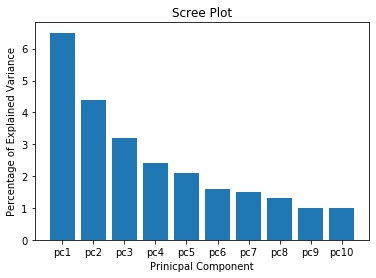

In [0]:
# remove PC from 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
per_var = per_var[:10] #top 10 PC - this number is chosen just so that we can more easily view the plot
labels = col_names[:10]

plt.bar(x=range(1, len(per_var)+1), height = per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Prinicpal Component')
plt.title('Scree Plot')
plt.show()

**Table with % Variance for the 1213 PCs making up 90% of the variance**

In [0]:
per_var_all = np.round(pca.explained_variance_ratio_* 100, decimals=1)
per_var_all.shape # this shows the % variance explained for each component

# convert to dataframe
per_var_all = pd.DataFrame(per_var_all)

# add prinicipal component labels
per_var_all.index = col_names[:1213]

# rename column 0
cols = {'% Variance'}
per_var_all.columns = cols

# create a rolling calculation of the variance 
per_var_all['Cumulative % Variance'] = per_var_all['% Variance'].cumsum()
per_var_all

# save to csv 
per_var_all.to_csv('/content/drive/My Drive/Projects/Breast_Cancer_Classification/Processed_Data/component_variance_chart_90.txt')

**Draw PCA Plot**

With the two primary principal components

References: 

https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [0]:
# Can use the function below with .sample to select a subset of PC components, making it more readible
principalDf_samp = principalDf.sample(n = 500) # will need to change the dataframe principalDf below to prinicpalDf_samp if I use this function

#plt.scatter(principalDf.pc1, principalDf.pc2)
plt.title('Principal Components')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

# Replace Labels
gene_data['EVENT'].replace(0, 'Lived',inplace=True)
gene_data['EVENT'].replace(1, 'Died',inplace=True)

# Create labels for the targets to be used to color the graphs
targets = ['Lived', 'Died']
colors = ['b', 'r']

for target, color in zip(targets, colors):
    indicesToKeep = gene_data['EVENT'] == target
    plt.scatter(principalDf.loc[indicesToKeep, 'pc1'],
                principalDf.loc[indicesToKeep, 'pc2'], c = color)

# The labeled numbers are the indiviudal patients samples
for sample in principalDf.index:
  plt.annotate(sample, (principalDf.pc1.loc[sample], principalDf.pc2.loc[sample])) # my impression is that sample just indicates each row

# Subset
#sample_50 = principalDf.sample(n = 50)

# This plot is interesting -- it looks like it's creating random samples, but still impossing it on the main graph because we are indeicating pc1 and pc2 still which all samples would be under
#for sample in sample_50.index:
#  plt.annotate(sample, (sample_50.pc1.loc[sample], sample_50.pc2.loc[sample]))
#print(sample_50)

#print(principalDf.sample) -- I believe sample is returning just all of the row labels -- hard to read though which is why I was trying to subset
#print(principalDf.sample(n = 50))

**Determine Relevant Genes**

Get the name of the top 10 genes that contribute most to pc1. The following code looks at the components of each pca - which is also called the loading scores. Sorting by the absolute value, allows us to identify which genes, in either the negative or positive direction, had the most infleunce on each prinicipal component.



References: 

https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components

https://www.youtube.com/watch?v=FgakZw6K1QQ

In [0]:
## first, get the loading scores
loading_scores = pd.Series(pca.components_[0], index=features)

## now sort the loading scores based on their magnitude
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
 
# get the names of the top 10 genes
top_10_genes = sorted_loading_scores[0:10].index.values
 
## print the gene names and their scores (and +/- sign)
print(loading_scores[top_10_genes])

**Loading Scores Test**

We can also validate the above loading scores function by looking at the values obtained when just using pca.fit. Firsrt, we perform just the fit function on the original x which is the scaled/standardized data. Then we can view the compoenent/loading scores which allow us to examine which genes had the most influence for each component. It is the absolute value 

In [0]:
# Test
principalComponents = pca.fit(x)
df_test = pd.DataFrame(pca.components_, columns=list(x.columns))  
print(df_test.SEPT15)
print(df_test.GLRX3)

In [0]:
pca.components_.shape # when we look at the shape, there are 1213 rows (components) and 24368 columns for the gene features 

**Select the Top 1213 Prinicipal Components that Explain 90 % of the Variance**

In [0]:
principalDf = principalDf.iloc[:,0:1213]

In [0]:
principalDf

**Save the selected PCA Components**

In [0]:
principalDf.to_csv('/content/drive/My Drive/Projects/Breast_Cancer_Classification/Processed_Data/gene_pca_components_90.txt')